In [1]:
# Install required libraries.
# Acknowledge and proceed if a dependency conflict warning for `fsspec` is displayed;
# the installed version is crucial for HuggingFace compatibility.

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

# Load the data from hugging face

Dataset used in this project contains Amazon product descriptions paired with their corresponding prices. It includes detailed product information from a variety of categories, providing text descriptions and pricing data ideal for training and evaluating price prediction models based on natural language product content.

https://huggingface.co/datasets/ed-donner/pricer-data/viewer/default/train?views%5B%5D=train

In [4]:
DATASET_NAME = "ed-donner/pricer-data"
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/914k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
train[0]

{'text': 'How much does this cost to the nearest dollar?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7\n\nPrice is $227.00',
 'price': 226.95}

In [6]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K\n\nPrice is $",
 'price': 374.41}

# Prepare the base `Llama-3.1-8b` model for evaluation

In [7]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"

QUANT_4_BIT = True

In [8]:
# Configure quantization settings based on QUANT_4_BIT flag.

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [9]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)

base_model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [10]:
print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

Memory footprint: 5.6 GB


# Helper functions for evaluation

In [11]:
def extract_price(s):
    """
    Extracts the first numeric price value from a given string.

    The function looks for the pattern "Price is $" in the input string,
    then extracts and returns the first floating-point or integer number
    following that pattern. The extracted numeric string may contain commas
    which are removed before conversion. If no valid number is found,
    the function returns 0.

    Args:
        s (str): Input string potentially containing a price.

    Returns:
        float: Extracted price value as a float. Returns 0 if no price found.

    Example:
        extract_price("The Price is $1,234.56 for this item") returns 1234.56
    """

    # Check if the input string contains the expected price prefix
    if "Price is $" in s:

        # Split string to get the part after "Price is $"
        contents = s.split("Price is $", 1)[1]

        # Remove commas and dollar sign if present in the substring
        contents = contents.replace(',', '').replace('$', '')

        # Use regex to find the first number (int or float) in the cleaned string
        match = re.search(r"[-+]?\d*\.\d+|\d+", contents)

        # Return the float value if match is found, otherwise 0
        return float(match.group()) if match else 0

    # Return 0 if "Price is $" pattern does not exist
    return 0


In [12]:
extract_price("Price is $999, thats so cheap")

999.0

In [13]:
def model_predict(prompt):
    """
    Generates a prediction from the base language model given an input prompt,
    then extracts and returns a price value from the model's response.

    The function sets a fixed random seed for reproducibility, tokenizes the input
    prompt, performs generation on the GPU with attention masking, decodes the
    generated tokens back to text, and extracts a numeric price from the generated text.

    Args:
        prompt (str): Input text prompt for the language model.

    Returns:
        float: Extracted price from the model's generated response using extract_price().

    Notes:
        - Assumes that `tokenizer`, `base_model`, and `extract_price` are
          defined and accessible in the same scope.
        - Sets a fixed seed (42) to ensure reproducible outputs.
        - Uses a generation limit of 4 new tokens for controlled output length.
        - Uses CUDA device for faster tensor operations if available.
    """
    # Fix the random seed for reproducibility of results
    set_seed(42)

    # Encode the input prompt into token IDs and move tensors to CUDA device
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")

    # Create attention mask of ones with the same shape as input tokens on CUDA device
    attention_mask = torch.ones(inputs.shape, device="cuda")

    # Generate model outputs, limiting the generation length to 4 tokens
    outputs = base_model.generate(
        inputs,
        max_new_tokens=4,
        attention_mask=attention_mask,
        num_return_sequences=1
    )

    # Decode the generated token IDs back to string form
    response = tokenizer.decode(outputs[0])

    # Extract and return the price value from the generated response text
    return extract_price(response)


In [14]:
model_predict(test[0]['text'])

1800.0

In [15]:
# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

# Evaluation

In [16]:
# tester class
class Tester:
    """
    A utility class to evaluate and visualize the performance of a prediction model.

    This class runs the predictor function against a dataset, calculates error metrics,
    assigns color-coded performance categories, and provides a summary report along
    with a scatter plot comparing ground truth prices to model estimates.

    Attributes:
        predictor (callable): A function that takes input text and returns a predicted price.
        data (list): Dataset of dictionaries with keys 'text' and 'price'.
        title (str): Optional descriptive title for the test, derived from predictor if not provided.
        size (int): Number of data points to evaluate (default 250).
        guesses (list): Stores predictor outputs for each datapoint.
        truths (list): Stores actual ground truth prices.
        errors (list): Absolute error between guess and truth.
        sles (list): Squared logarithmic errors (SLE) for more robust error measure.
        colors (list): Color labels ('green', 'orange', 'red') representing error magnitude.
    """

    def __init__(self, predictor, data, title=None, size=250):
        """Initializes the Tester with model predictor, data, optional title and evaluation size."""
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        """
        Determines a color label based on the error magnitude relative to the truth value.

        Args:
            error (float): Absolute difference between prediction and ground truth.
            truth (float): Ground truth price value.

        Returns:
            str: "green" for low errors,
                 "orange" for moderate errors,
                 "red" for high errors.
        """
        if error < 40 or error / truth < 0.2:
            return "green"
        elif error < 80 or error / truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        """
        Runs prediction and error calculation on a single datapoint, stores the results,
        and prints a color-coded summary line.

        Args:
            i (int): Index of the datapoint in the dataset.
        """
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth + 1) - math.log(guess + 1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        # Extract a shortened snippet from the text for display
        title = datapoint["text"].split("\n\n")[1][:20] + "..." if "\n\n" in datapoint["text"] else datapoint["text"][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i + 1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        """
        Generates a scatter plot comparing ground truth prices and model predictions.
        A diagonal reference line is added for perfect prediction.

        Args:
            title (str): Title to display on the plot.
        """
        max_val = max(max(self.truths), max(self.guesses))
        plt.figure(figsize=(12, 8))
        # Diagonal line of perfect predictions for reference
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        # Scatter plot with colors indicating error magnitude
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        """
        Computes aggregate error metrics and generates a summary report
        with a visualization of performance.
        """
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(color == "green" for color in self.colors)
        title = (
            f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} "
            f"Hits={hits / self.size * 100:.1f}%"
        )
        self.chart(title)

    def run(self):
        """
        Executes the full evaluation running all datapoints and generating the final report.
        """
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        """
        Convenience class method for quickly running tests without manual instantiation.

        Args:
            function (callable): Predictor function to evaluate.
            data (list): Dataset of input dictionaries with 'text' and 'price'.
        """
        cls(function, data).run()


1: Guess: $1,800.00 Truth: $374.41 Error: $1,425.59 SLE: 2.46 Item: OEM AC Compressor w/...
2: Guess: $25.00 Truth: $225.11 Error: $200.11 SLE: 4.68 Item: Motorcraft YB3125 Fa...
3: Guess: $25.00 Truth: $61.68 Error: $36.68 SLE: 0.77 Item: Dorman Front Washer ...
4: Guess: $1,999.00 Truth: $599.99 Error: $1,399.01 SLE: 1.45 Item: HP Premium HD Plus T...
5: Guess: $7.50 Truth: $16.99 Error: $9.49 SLE: 0.56 Item: Super Switch Pickup ...
6: Guess: $1.00 Truth: $31.99 Error: $30.99 SLE: 7.86 Item: Horror Bookmarks, Re...
7: Guess: $89.99 Truth: $101.79 Error: $11.80 SLE: 0.01 Item: SK6241 - Stinger 4 G...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Lig...
9: Guess: $299.00 Truth: $635.86 Error: $336.86 SLE: 0.57 Item: Randall G3 Plus Comb...
10: Guess: $25.99 Truth: $65.99 Error: $40.00 SLE: 0.83 Item: HOLDWILL 6 Pack LED ...
11: Guess: $110.00 Truth: $254.21 Error: $144.21 SLE: 0.69 Item: Viking Horns 3 Gallo...
12: Guess: $1,800.00 Truth: $412.99 Error

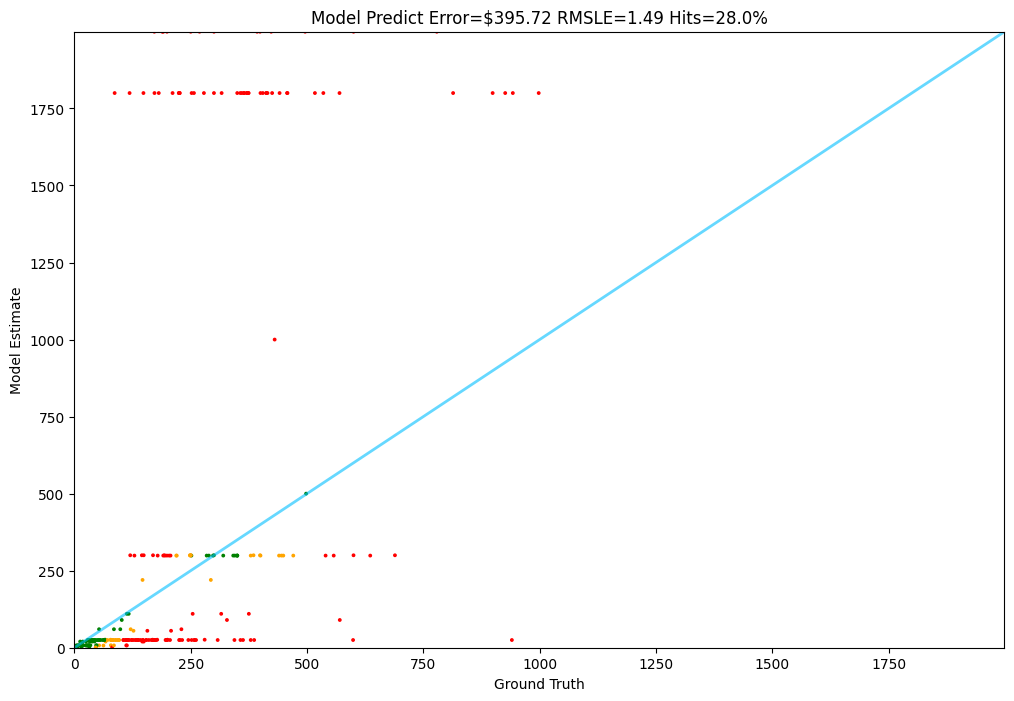

In [17]:
Tester.test(model_predict, test)

Key Observations:
1. The scatter plot of predicted vs. ground truth values shows a large number of overpredictions, visible as many points far above the diagonal reference line.

2. Many points are clustered on or near the top edge of the plot, suggesting the model frequently outputs very high predictions, regardless of the actual (ground truth) value.

3. The concentration of red points, which likely denote high errors, highlights a systematic problem with large overestimates.

4. There are also points near zero or on the lower left, representing cases where the model is closer to the actual value.

- The model’s accuracy is unsatisfactory, with high error metrics and poor calibration, especially for high-value ground-truth cases. The scatter pattern and metrics suggest the need for finetuning the model for this usecase.